In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

# Configure visualizations PROPERLY
sns.set_theme(style='whitegrid', rc={'figure.figsize':(14,6)})
%matplotlib inline


In [2]:
# ## 1. Data Loading & Preprocessing

# %% [code]
# Load datasets
real_df = pd.read_csv('Gemini_BTCUSD_1h.csv', parse_dates=['date'], index_col='date')
synth_df = pd.read_csv('synthetic_crypto_data.csv', parse_dates=['date'], index_col='date')

# Clean real data
real_df = real_df[['symbol', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']]
real_df.rename(columns={'Volume BTC':'Volume_BTC', 'Volume USD':'Volume_USD'}, inplace=True)

# Clean synthetic data
synth_df.rename(columns={'Volume BTC':'Volume_BTC', 'Volume USD':'Volume_USD'}, inplace=True)

In [ ]:
# Create combined dataframe
combined_df = pd.concat({
    'Real': real_df.resample('5T').ffill(),
    'Synthetic': synth_df
}, axis=0)

Real Data Statistics:
                open           high            low          close  \
count   83000.000000   83000.000000   83000.000000   83000.000000   
mean    23559.655367   23663.777942   23449.960007   23560.705674   
std     24752.198876   24853.443276   24646.407517   24753.050532   
min         0.000000     243.600000       0.000000     243.600000   
25%      4744.827500    4764.095000    4719.817500    4745.642500   
50%     11351.540000   11396.415000   11284.515000   11351.710000   
75%     38143.570000   38383.655000   37883.512500   38146.657500   
max    108312.350000  109027.220000  107645.660000  108312.350000   

         Volume_BTC    Volume_USD  
count  83000.000000  8.300000e+04  
mean     103.696947  1.473377e+06  
std      224.341399  2.913467e+06  
min        0.000000  0.000000e+00  
25%       12.519633  1.229906e+05  
50%       38.301330  5.171473e+05  
75%      102.889118  1.590948e+06  
max     8526.751048  1.039629e+08  

Synthetic Data Statistics:
    

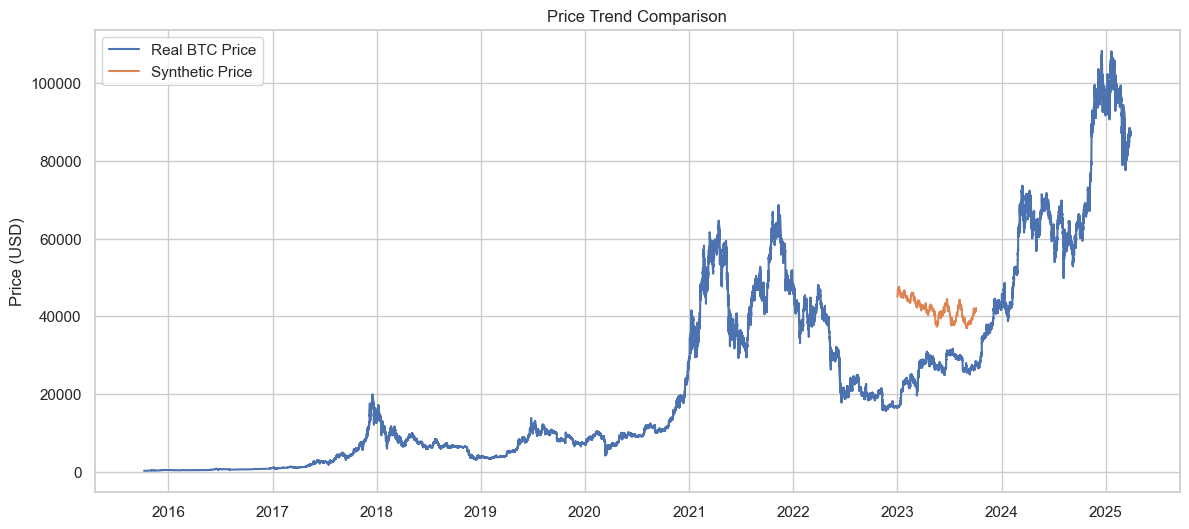

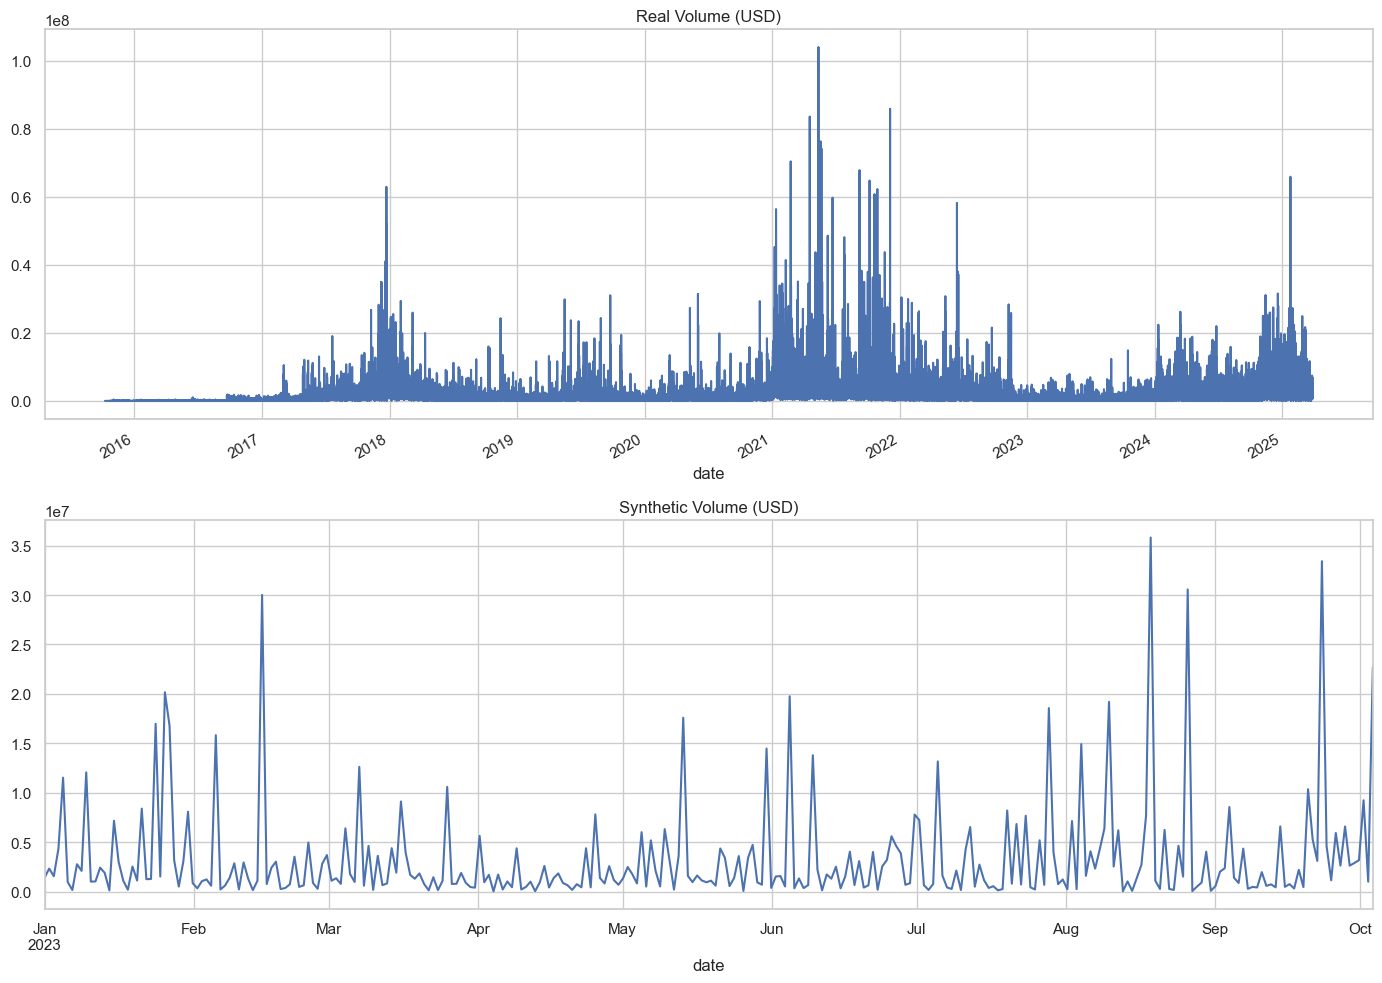

In [4]:
# ## 2. Exploratory Data Analysis (EDA)

# %% [code]
# Basic statistics
print("Real Data Statistics:")
print(real_df.describe())
print("\nSynthetic Data Statistics:")
print(synth_df.describe())

# Price trend comparison
plt.figure(figsize=(14,6))
plt.plot(real_df['close'], label='Real BTC Price')
plt.plot(synth_df['close'], label='Synthetic Price')
plt.title('Price Trend Comparison')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Volume analysis
fig, ax = plt.subplots(2, 1, figsize=(14,10))
real_df['Volume_USD'].plot(ax=ax[0], title='Real Volume (USD)')
synth_df['Volume_USD'].plot(ax=ax[1], title='Synthetic Volume (USD)')
plt.tight_layout()
plt.show()

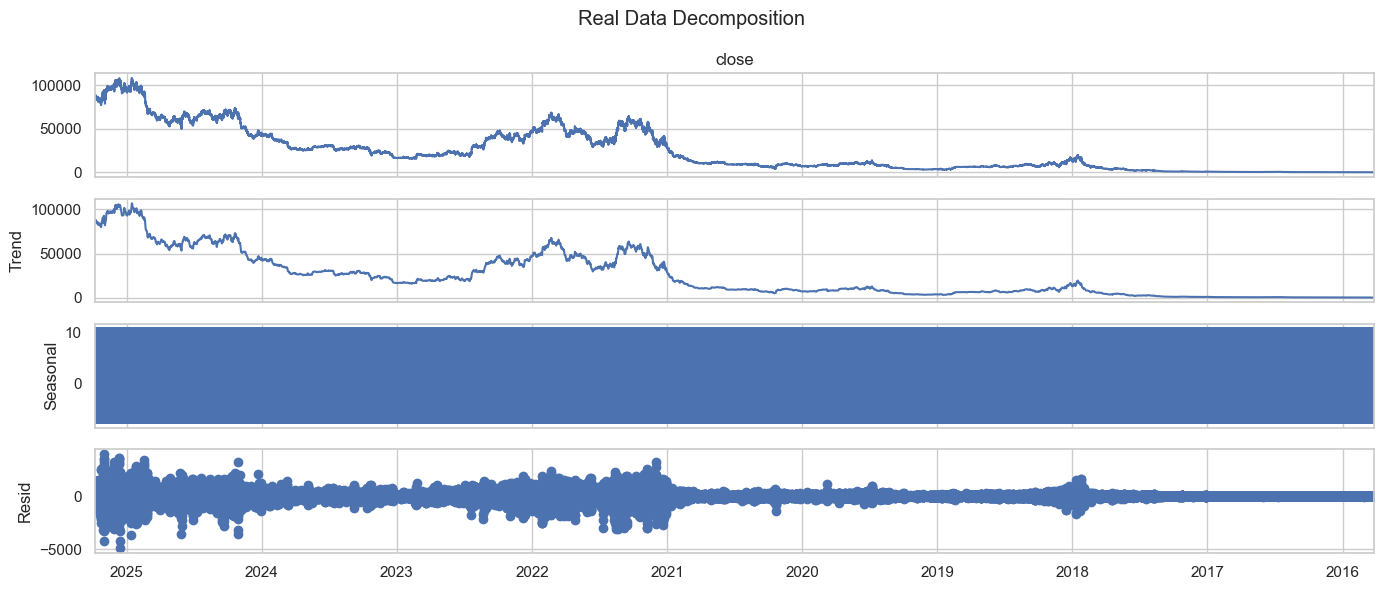

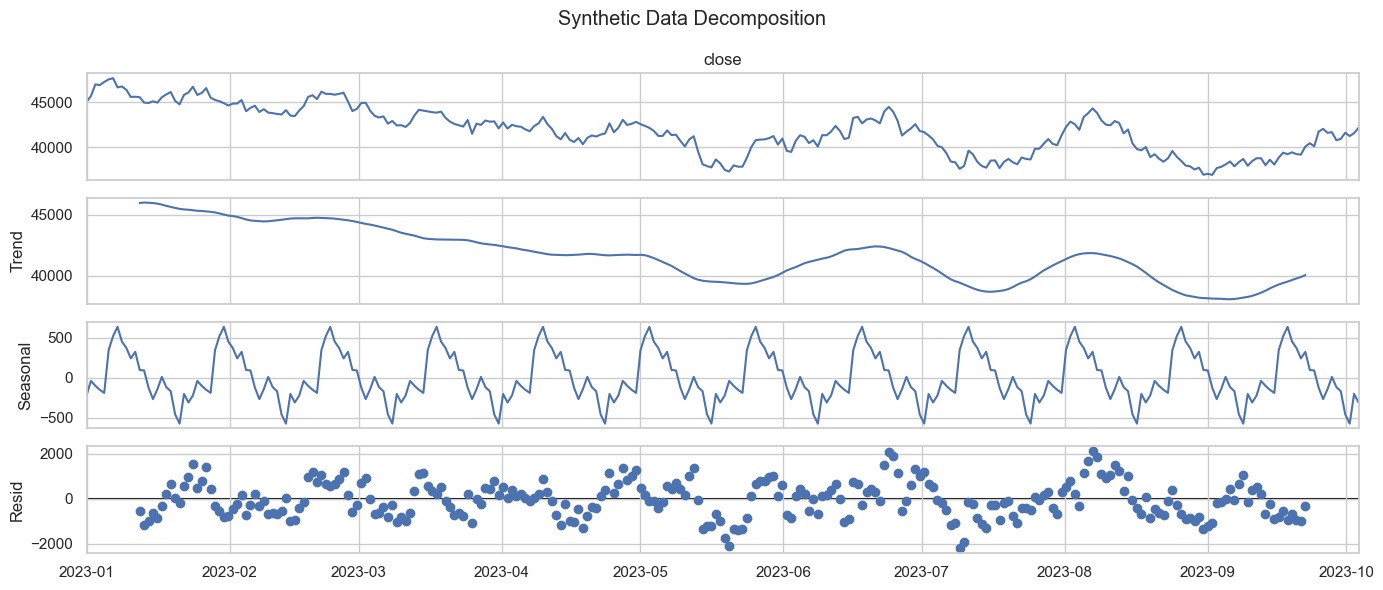

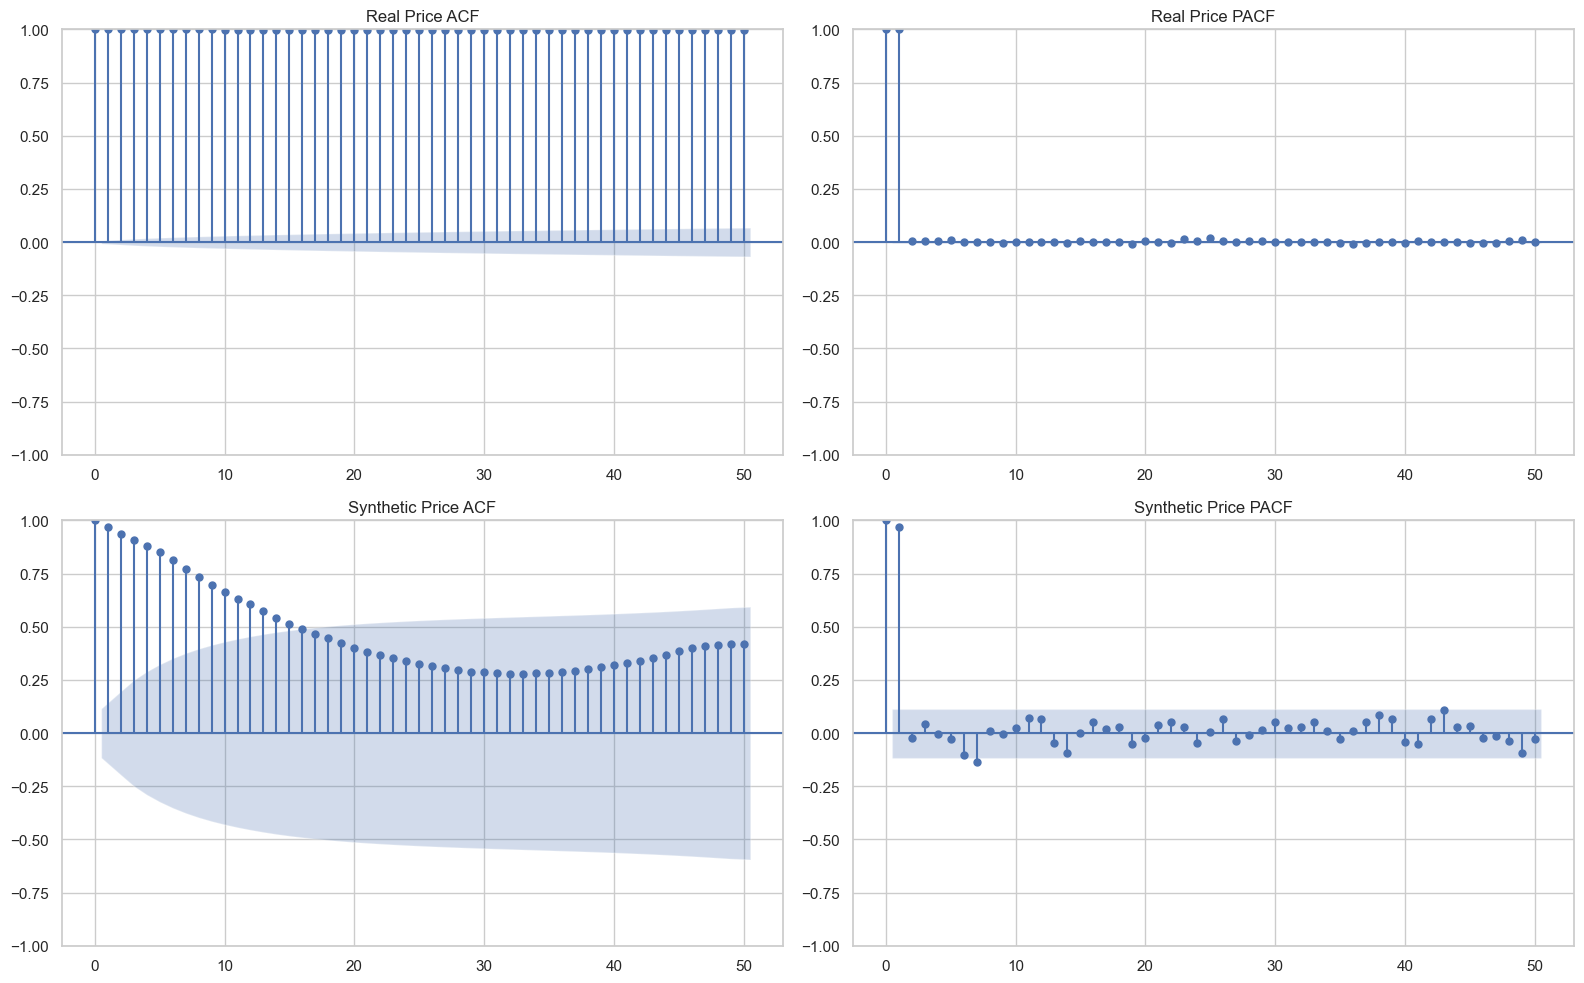

In [5]:
# ## 3. Time Series Analysis

# %% [code]
# Decompose time series
def plot_decomposition(series, title):
    result = seasonal_decompose(series, model='additive', period=24)
    result.plot()
    plt.suptitle(title)
    plt.tight_layout()

plot_decomposition(real_df['close'], 'Real Data Decomposition')
plot_decomposition(synth_df['close'], 'Synthetic Data Decomposition')

# Autocorrelation analysis
fig, ax = plt.subplots(2, 2, figsize=(16,10))
plot_acf(real_df['close'], lags=50, ax=ax[0,0], title='Real Price ACF')
plot_pacf(real_df['close'], lags=50, ax=ax[0,1], title='Real Price PACF')
plot_acf(synth_df['close'], lags=50, ax=ax[1,0], title='Synthetic Price ACF')
plot_pacf(synth_df['close'], lags=50, ax=ax[1,1], title='Synthetic Price PACF')
plt.tight_layout()
plt.show()

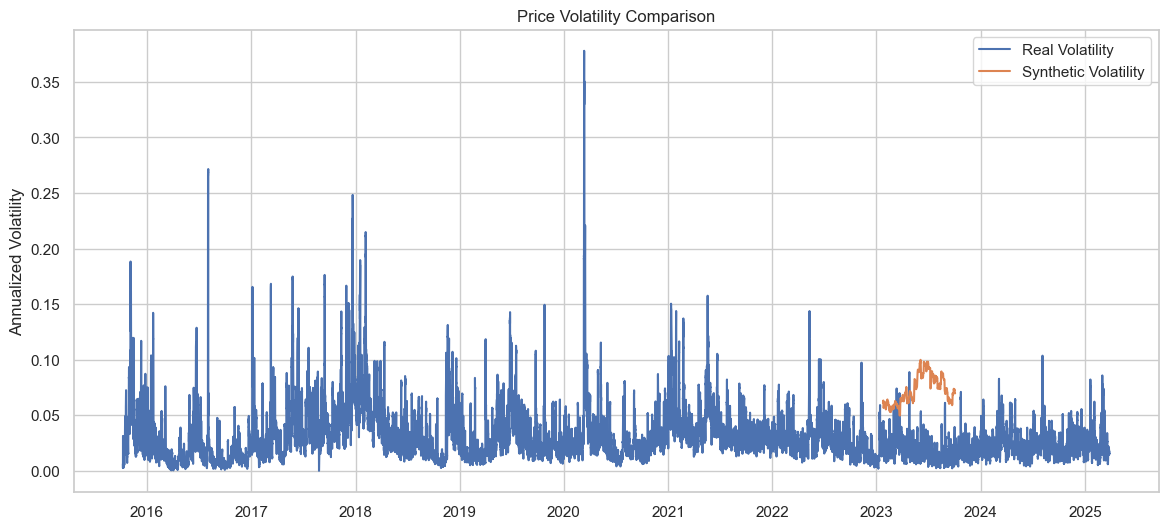

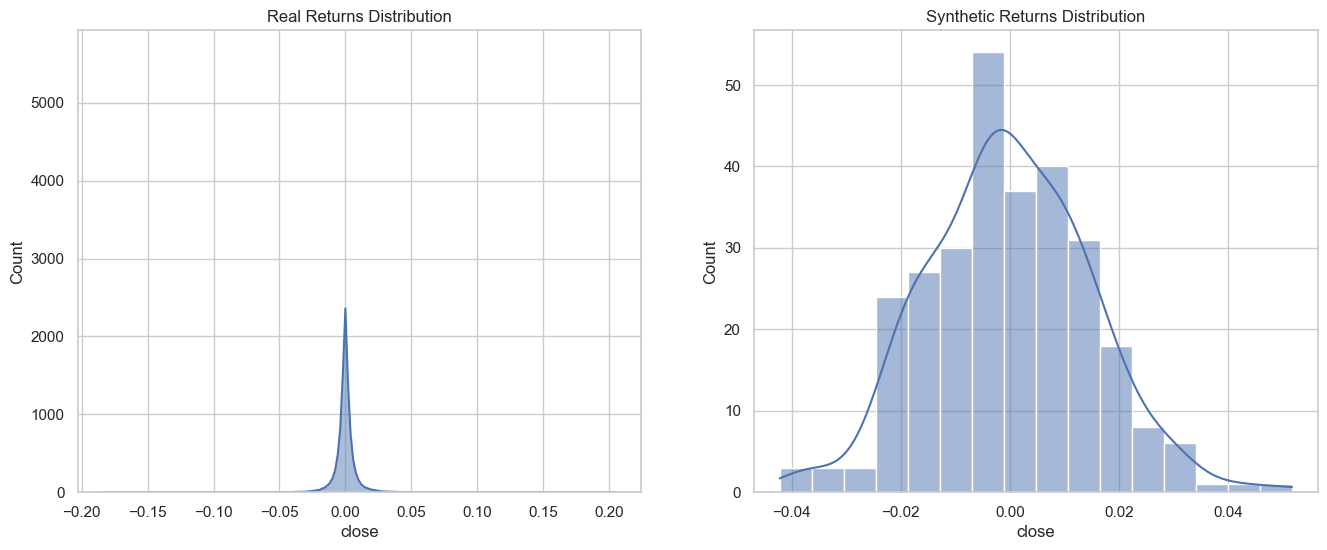

In [6]:
# ## 4. Statistical Comparison

# %% [code]
# Volatility comparison
def calculate_volatility(df):
    returns = np.log(df['close']).diff().dropna()
    return returns.rolling(window=24).std() * np.sqrt(24)

real_vol = calculate_volatility(real_df)
synth_vol = calculate_volatility(synth_df)

plt.figure(figsize=(14,6))
plt.plot(real_vol, label='Real Volatility')
plt.plot(synth_vol, label='Synthetic Volatility')
plt.title('Price Volatility Comparison')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.show()

# Distribution comparison
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(np.log(real_df['close']).diff().dropna(), kde=True, ax=ax[0], label='Real')
sns.histplot(np.log(synth_df['close']).diff().dropna(), kde=True, ax=ax[1], label='Synthetic')
ax[0].set_title('Real Returns Distribution')
ax[1].set_title('Synthetic Returns Distribution')
plt.show()

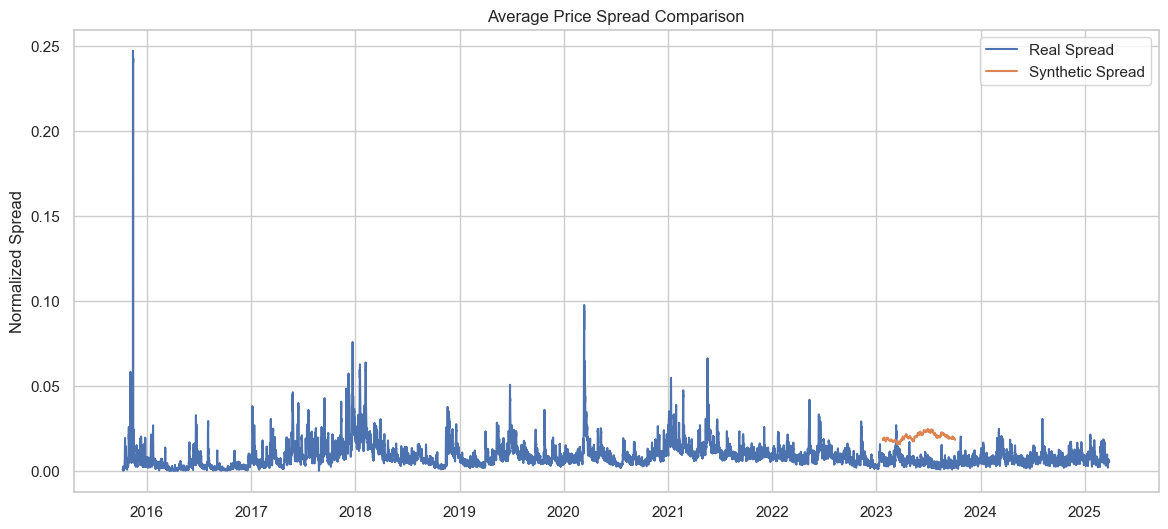

Real Data Volume-Price Correlation: 0.30
Synthetic Data Volume-Price Correlation: 0.03


In [7]:
# ## 5. Market Microstructure Analysis

# %% [code]
# Spread analysis
def calculate_spread(df):
    df['spread'] = (df['high'] - df['low']) / df['open']
    return df

real_df = calculate_spread(real_df)
synth_df = calculate_spread(synth_df)

plt.figure(figsize=(14,6))
plt.plot(real_df['spread'].rolling(24).mean(), label='Real Spread')
plt.plot(synth_df['spread'].rolling(24).mean(), label='Synthetic Spread')
plt.title('Average Price Spread Comparison')
plt.ylabel('Normalized Spread')
plt.legend()
plt.show()

# Volume-price correlation
real_corr = real_df[['close', 'Volume_USD']].corr().iloc[0,1]
synth_corr = synth_df[['close', 'Volume_USD']].corr().iloc[0,1]

print(f"Real Data Volume-Price Correlation: {real_corr:.2f}")
print(f"Synthetic Data Volume-Price Correlation: {synth_corr:.2f}")
